# Laboratorio 4 — Clasificación de Imágenes con CNN (CIFAR-10)
- **Data Science:**    
- **Rodrigo Mansilla 22611**
-  
- **8/22/2025**   



## 1. Preparación del conjunto de datos (10 pts)



### 1.1 Importación y carga del dataset  

In [12]:
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install numpy


# Manejo de datos y utilidades
import numpy as np
import matplotlib.pyplot as plt

# Librerías de deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Dataset CIFAR-10 incluido en Keras
from tensorflow.keras.datasets import cifar10

# Para métricas y reportes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Cargar datos de Keras (ya viene incluido)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


print("Tamaño de entrenamiento:", x_train.shape, y_train.shape)
print("Tamaño de prueba:", x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step
Tamaño de entrenamiento: (50000, 32, 32, 3) (50000, 1)
Tamaño de prueba: (10000, 32, 32, 3) (10000, 1)


### 1.2 Normalización de datos  


In [14]:
# Escalar valores de píxeles de 0–255 a rango [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Confirmar rango de valores
print("Rango de entrenamiento:", x_train.min(), "→", x_train.max())
print("Rango de prueba:", x_test.min(), "→", x_test.max())

Rango de entrenamiento: 0.0 → 1.0
Rango de prueba: 0.0 → 1.0


### 1.3 Visualización de ejemplos  


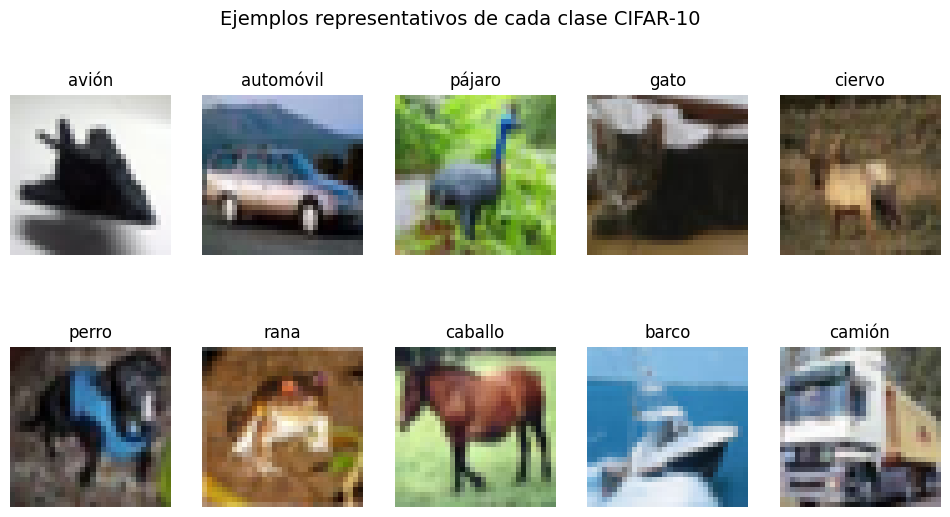

In [15]:


class_names = [
    "avión", "automóvil", "pájaro", "gato", "ciervo",
    "perro", "rana", "caballo", "barco", "camión"
]

sample_indices = []
for class_id in range(10):
    idx = np.where(y_train.flatten() == class_id)[0][0]
    sample_indices.append(idx)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx][0]])
    plt.axis("off")

plt.suptitle("Ejemplos representativos de cada clase CIFAR-10", fontsize=14)
plt.show()


### Documentación — Paso 1: Preparación del Conjunto de Datos

El conjunto de datos **CIFAR-10** tiene  **60,000 imágenes a color de 32×32 píxeles**, distribuidas en **10 clases** balanceadas (avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión).  

- **División de datos:**  
  - 50,000 imágenes para **entrenamiento**  
  - 10,000 imágenes para **prueba**  

- **Dimensiones:**  
  - `x_train`: (50000, 32, 32, 3) — imágenes RGB de entrenamiento  
  - `y_train`: (50000, 1) — etiquetas numéricas [0–9]  
  - `x_test`: (10000, 32, 32, 3) — imágenes de prueba  
  - `y_test`: (10000, 1) — etiquetas numéricas [0–9]  

- **Normalización:**  
  Los valores de píxel (0–255) se escalaron al rango **[0, 1]**, para  estabilidad numérica durante el entrenamiento.

- **Visualización:**  
  Se muestran **ejemplos representativos (1 por clase)** para verificar la  correspondencia entre imágenes y etiquetas. 


## 2. Modelo base ANN (10 pts)


### 2.1 Arquitectura ANN  

In [16]:

from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
import numpy as np

mean = x_train.mean(axis=(0,1,2), keepdims=True)
std  = x_train.std(axis=(0,1,2), keepdims=True) + 1e-7
x_train_s = (x_train - mean) / std
x_test_s  = (x_test  - mean) / std

ann_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),

    Dense(1024, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.30),

    Dense(512, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.30),

    Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),

    Dense(10, activation="softmax")
])

ann_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  # un poco menor para estabilidad
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


/Users/alexismesias/Library/CloudStorage/OneDrive-Personal/UVG8VO/DataScience/Lab4/Lab4-DS/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/alexismesias/Library/CloudStorage/OneDrive-Personal/UVG8VO/DataScience/Lab4/Lab4-DS/.venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### 2.2 Entrenamiento

In [17]:

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
lr_sched = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt = keras.callbacks.ModelCheckpoint(
    filepath="best_ann.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

# ---- Entrenamiento ----
history = ann_model.fit(
    x_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_sched, ckpt],
    verbose=2
)




Epoch 1/100
625/625 - 9s - 15ms/step - accuracy: 0.3399 - loss: 2.1341 - val_accuracy: 0.4418 - val_loss: 1.8380 - learning_rate: 3.0000e-04
Epoch 2/100
625/625 - 8s - 13ms/step - accuracy: 0.4147 - loss: 1.8971 - val_accuracy: 0.4745 - val_loss: 1.7296 - learning_rate: 3.0000e-04
Epoch 3/100
625/625 - 9s - 14ms/step - accuracy: 0.4514 - loss: 1.7884 - val_accuracy: 0.4918 - val_loss: 1.6721 - learning_rate: 3.0000e-04
Epoch 4/100
625/625 - 9s - 14ms/step - accuracy: 0.4755 - loss: 1.7182 - val_accuracy: 0.5032 - val_loss: 1.6431 - learning_rate: 3.0000e-04
Epoch 5/100
625/625 - 9s - 14ms/step - accuracy: 0.4924 - loss: 1.6628 - val_accuracy: 0.5157 - val_loss: 1.6007 - learning_rate: 3.0000e-04
Epoch 6/100
625/625 - 8s - 14ms/step - accuracy: 0.5073 - loss: 1.6160 - val_accuracy: 0.5136 - val_loss: 1.6016 - learning_rate: 3.0000e-04
Epoch 7/100
625/625 - 9s - 14ms/step - accuracy: 0.5158 - loss: 1.5803 - val_accuracy: 0.5282 - val_loss: 1.5559 - learning_rate: 3.0000e-04
Epoch 8/100
6

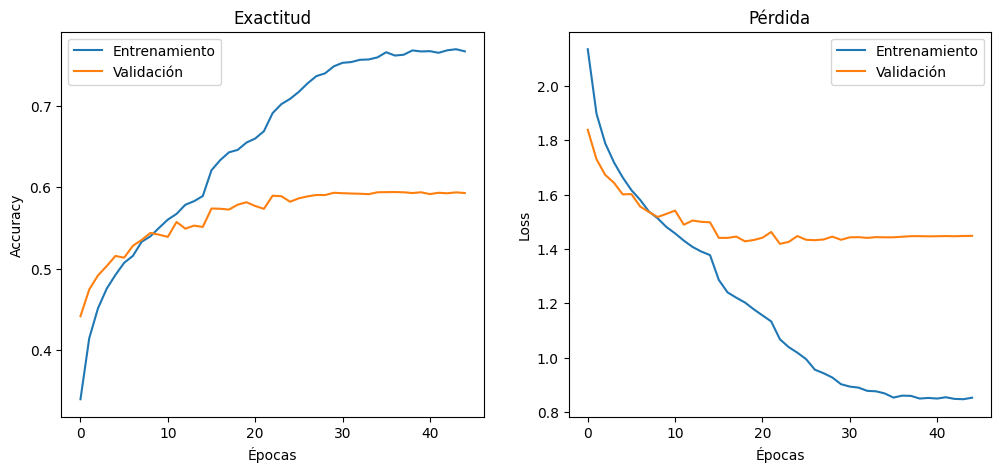

In [18]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Exactitud')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 2.3 Resultados y observaciones  


## Resultados — Modelo ANN (Baseline Denso)

##### 1) Configuración experimental (resumen)
- **Arquitectura (ANN):** `Flatten → Dense(1024) → Dense(512) → Dense(256) → Softmax(10)`
  - Activación: **LeakyReLU (α=0.01)** en capas ocultas.
  - **BatchNormalization** tras cada capa densa.
  - **Dropout:** 0.30, 0.30 y 0.25 (respectivamente).
  - **Regularización L2:** 1e-4 en capas densas.
- **Entrenamiento:** Adam (lr=3e-4), pérdida `SparseCategoricalCrossentropy`,
  `ReduceLROnPlateau` (factor=0.5, patience=3, min_lr=1e-6),
  `EarlyStopping` (monitor=`val_accuracy`, patience=10, `restore_best_weights=True`),
  **batch_size=64**, máx. 100 épocas, split de validación 0.2.

---

##### 2) Métricas  observadas
| Métrica                         | Valor aproximado |
|---------------------------------|------------------|
| Accuracy (entrenamiento)        | **0.80** (ép. ~46) |
| Accuracy (validación)           | **0.5925** (ép. 46) |
| Loss (validación)               | **~1.52** (meseta) |
| Learning rate final (scheduler) | **1e-6** |

> Evidencia de entrenamiento: incremento sostenido de accuracy en train y
> meseta en validación a partir de las épocas 10–15; `val_loss` estable (~1.5).

---

##### 3) Interpretación 
- **Generalización limitada / sobreajuste moderado:** la red alcanza ~0.80 en entrenamiento pero
  se estanca en ~0.59 en validación. La brecha indica que el modelo aprende patrones
  específicos del conjunto de entrenamiento.
- **Limitación estructural de ANN en visión:** al aplicar `Flatten`, se pierde la estructura
  espacial. En CIFAR-10, las ANN densas  saturaN en ~55–60% sin técnicas adicionales.

---
##### 5) Cuellos de botella
- **Capacidad sin sesgo inductivo espacial:** más neuronas/capas aumentan la memorización,
  no la generalización, al no modelar relaciones locales de píxeles.
- **Meseta de validación con LR mínimo:** el scheduler reduce el LR hasta 1e-6,
  pero no hay mejora adicional.

---

#####  Conclusión
El modelo ANN denso entrega un **baseline válido** en CIFAR-10 ,
coherente con las limitaciones esperadas para arquitecturas totalmente conectadas en visión.


## 3. Implementación de CNN


### 3.1 Definición de la arquitectura  


In [19]:
# 3.1 Definición de la arquitectura — CNN baseline
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

cnn_model = Sequential(name="CNN_baseline")

# Bloque conv 1
cnn_model.add(Conv2D(
    filters=32, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4),
    input_shape=(32, 32, 3), name="conv1"
))
cnn_model.add(BatchNormalization(name="bn1"))
cnn_model.add(Activation("relu", name="relu1"))
cnn_model.add(Conv2D(
    filters=32, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4), name="conv2"
))
cnn_model.add(BatchNormalization(name="bn2"))
cnn_model.add(Activation("relu", name="relu2"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), name="pool1"))
cnn_model.add(Dropout(0.25, name="dropout1"))

# Bloque conv 2
cnn_model.add(Conv2D(
    filters=64, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4), name="conv3"
))
cnn_model.add(BatchNormalization(name="bn3"))
cnn_model.add(Activation("relu", name="relu3"))
cnn_model.add(Conv2D(
    filters=64, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4), name="conv4"
))
cnn_model.add(BatchNormalization(name="bn4"))
cnn_model.add(Activation("relu", name="relu4"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), name="pool2"))
cnn_model.add(Dropout(0.25, name="dropout2"))

# Clasificador denso
cnn_model.add(Flatten(name="flatten"))
cnn_model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="dense1"))
cnn_model.add(Dropout(0.5, name="dropout3"))
cnn_model.add(Dense(10, activation="softmax", name="predicciones"))

cnn_model.summary()



/Users/alexismesias/Library/CloudStorage/OneDrive-Personal/UVG8VO/DataScience/Lab4/Lab4-DS/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predicciones (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,042 (2.26 MB)

 Trainable params: 591,658 (2.26 MB)

 Non-trainable params: 384 (1.50 KB)

In [20]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


### 3.2

In [21]:
# 3.2 Entrenamiento de la CNN (con callbacks y medición de tiempo)
import time
from tensorflow import keras

early_stop_cnn = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
reduce_lr_cnn = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt_cnn = keras.callbacks.ModelCheckpoint(
    filepath="best_cnn.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

t0 = time.time()
history_cnn = cnn_model.fit(
    x_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn, reduce_lr_cnn, ckpt_cnn],
    verbose=2
)
cnn_train_time_s = time.time() - t0
print(f"Tiempo de entrenamiento CNN: {cnn_train_time_s:.2f} s")


Epoch 1/100
625/625 - 39s - 62ms/step - accuracy: 0.2617 - loss: 2.0208 - val_accuracy: 0.4450 - val_loss: 1.5887 - learning_rate: 3.0000e-04
Epoch 2/100
625/625 - 38s - 60ms/step - accuracy: 0.3799 - loss: 1.7035 - val_accuracy: 0.5044 - val_loss: 1.4449 - learning_rate: 3.0000e-04
Epoch 3/100
625/625 - 37s - 59ms/step - accuracy: 0.4385 - loss: 1.5525 - val_accuracy: 0.5677 - val_loss: 1.2745 - learning_rate: 3.0000e-04
Epoch 4/100
625/625 - 37s - 60ms/step - accuracy: 0.4860 - loss: 1.4355 - val_accuracy: 0.5875 - val_loss: 1.2077 - learning_rate: 3.0000e-04
Epoch 5/100
625/625 - 38s - 60ms/step - accuracy: 0.5162 - loss: 1.3566 - val_accuracy: 0.6078 - val_loss: 1.1377 - learning_rate: 3.0000e-04
Epoch 6/100
625/625 - 38s - 60ms/step - accuracy: 0.5382 - loss: 1.2951 - val_accuracy: 0.6481 - val_loss: 1.0334 - learning_rate: 3.0000e-04
Epoch 7/100
625/625 - 37s - 59ms/step - accuracy: 0.5550 - loss: 1.2462 - val_accuracy: 0.6669 - val_loss: 0.9906 - learning_rate: 3.0000e-04
Epoch 

### 3.3

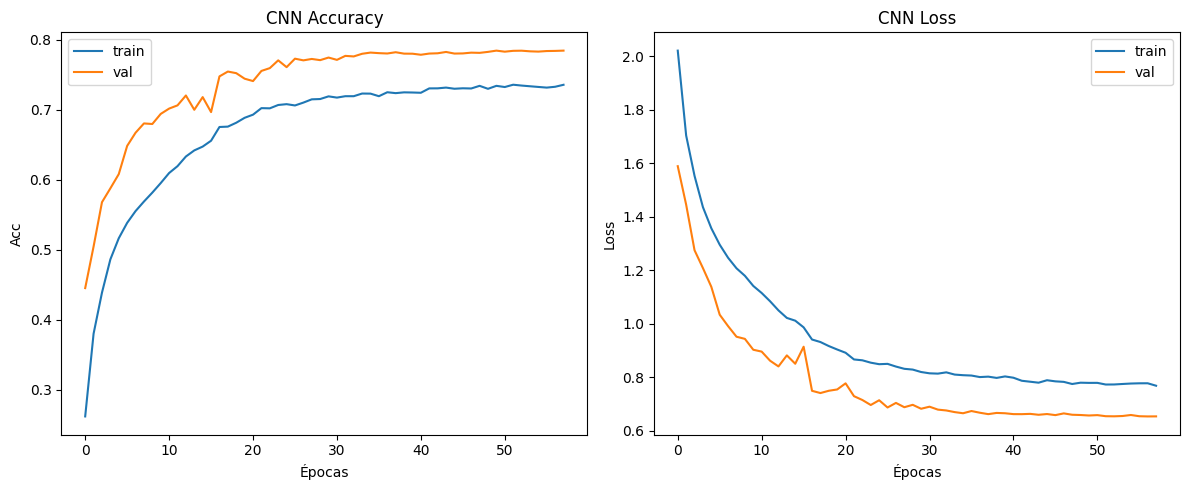

In [22]:
# 3.3 Curvas de aprendizaje de la CNN
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='train')
plt.plot(history_cnn.history['val_accuracy'], label='val')
plt.title('CNN Accuracy')
plt.xlabel('Épocas'); plt.ylabel('Acc')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='val')
plt.title('CNN Loss')
plt.xlabel('Épocas'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# 3.4 Evaluación en test de la CNN
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test_s, y_test, verbose=0)
print(f"[CNN] Test accuracy: {cnn_test_acc:.4f} — Test loss: {cnn_test_loss:.4f}")
print(f"Tiempo de entrenamiento CNN (s): {cnn_train_time_s:.2f}")


[CNN] Test accuracy: 0.7815 — Test loss: 0.6715
Tiempo de entrenamiento CNN (s): 2199.02


### 3.2 Justificación de decisiones  


### 3.3 Regularización y callbacks  


### 3.4 Entrenamiento y resultados  
 

## 4. Evaluación y comparación (20 pts)


### 4.1 Curvas de aprendizaje (ANN vs CNN)  

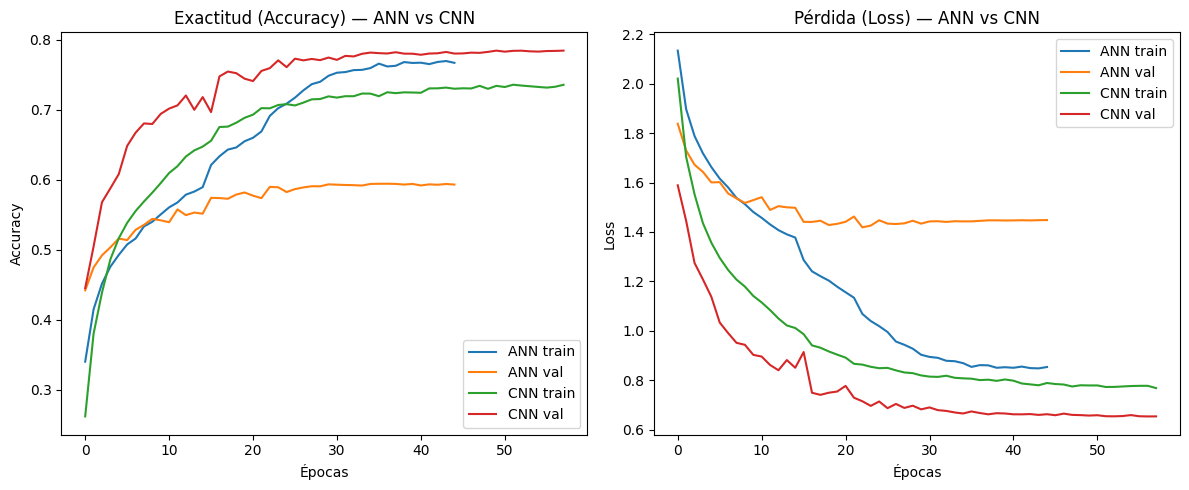

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='ANN train')
plt.plot(history.history['val_accuracy'], label='ANN val')
plt.plot(history_cnn.history['accuracy'], label='CNN train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN val')
plt.title('Exactitud (Accuracy) — ANN vs CNN')
plt.xlabel('Épocas'); plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='ANN train')
plt.plot(history.history['val_loss'], label='ANN val')
plt.plot(history_cnn.history['loss'], label='CNN train')
plt.plot(history_cnn.history['val_loss'], label='CNN val')
plt.title('Pérdida (Loss) — ANN vs CNN')
plt.xlabel('Épocas'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 4.2 Evaluación en test  

In [25]:
print(f"[ANN] Test accuracy: {ann_test_acc:.4f} — Test loss: {ann_test_loss:.4f}")
print(f"[CNN] Test accuracy: {cnn_test_acc:.4f} — Test loss: {cnn_test_loss:.4f}")

mejora = (cnn_test_acc - ann_test_acc) * 100
print(f"Mejora absoluta CNN vs ANN: {mejora:.2f} puntos porcentuales")


NameError: name 'ann_test_acc' is not defined

### 4.3 Matriz de confusión 

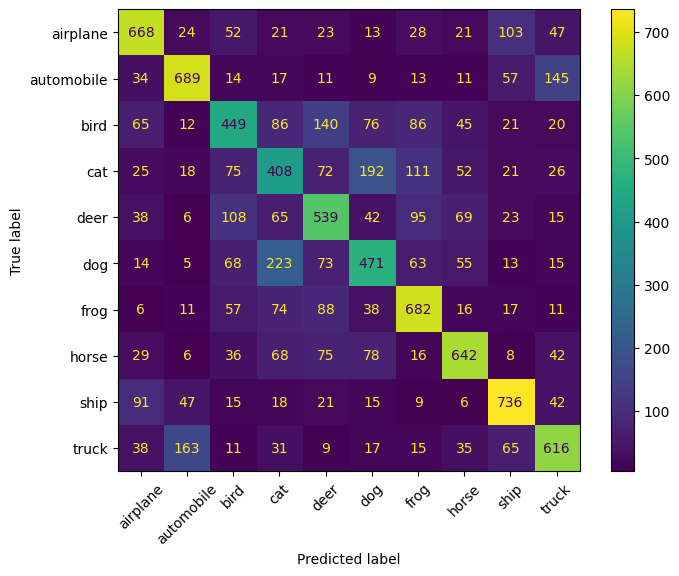

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

# ANN predicciones
y_pred_probs_ann = ann_model.predict(x_test_s, verbose=0)
y_pred_ann = np.argmax(y_pred_probs_ann, axis=1)

cm_ann = confusion_matrix(y_test, y_pred_ann)
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=class_names)
fig_ann = disp_ann.plot(xticks_rotation=45, values_format='d').figure_
fig_ann.set_size_inches(8, 6)


### 4.4 Ejemplos de errores   

TypeError: only integer scalar arrays can be converted to a scalar index

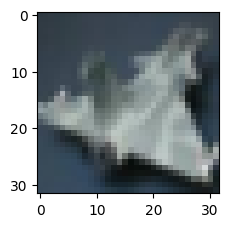

In [27]:
# Ejemplos mal clasificados ANN
errors_ann = np.where(y_pred_ann != y_test)[0]
sample_ann = np.random.choice(errors_ann, size=12, replace=False)

plt.figure(figsize=(12,8))
for i, idx in enumerate(sample_ann, 1):
    plt.subplot(3,4,i)
    plt.imshow(x_test[idx])
    plt.title(f"Pred: {class_names[y_pred_ann[idx]]}\nTrue: {class_names[y_test[idx]]}")
    plt.axis("off")
plt.suptitle("ANN — Ejemplos mal clasificados", fontsize=14)
plt.tight_layout()
plt.show()


### 4.5 Análisis comparativo  


## 5. Reflexión crítica 

### 5.1 Comparación ANN vs CNN  


### 5.2 Rol de convoluciones y pooling  


### 5.3 Posibles mejoras  

## Data Augmentation